In [127]:
import numpyro
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi 
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation
from matplotlib import pyplot as plt
import pandas as pd
from jax import random

rng_key = random.PRNGKey(0)

4M1

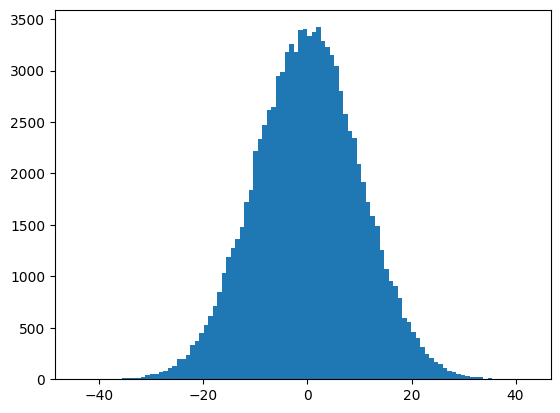

In [128]:
def model(y=None):
    mu = numpyro.sample("mu", dist.Normal(0, 10))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)


n_samples = 100000
samples = numpyro.infer.Predictive(model, num_samples=n_samples)(rng_key)
plt.hist(samples["y"], bins=100)
plt.show()

In [133]:
data_raw = pd.read_csv("../data/Howell1.csv", sep=";")

data = data_raw[data_raw.age >= 18]

4H1

In [130]:
weight_bar = data.weight.mean()

def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (weight - weight_bar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m,
    optim.Adam(1),
    Trace_ELBO(),
    weight=data.weight.values,
    height=data.height.values,
)
svi_result = svi.run(rng_key, 2000)
post = m.sample_posterior(rng_key, svi_result.params, (10000,))

weights = jnp.array([46.95, 43.72, 64.78, 32.59, 54.63])

sim = Predictive(m.model, post)(rng_key, weights, None)

height_mean = sim["mu"].mean(axis=0)

height_hdpi = hpdi(sim["height"], 0.89, axis=0)

print(height_mean)
print(height_hdpi)

100%|██████████| 2000/2000 [00:00<00:00, 8434.47it/s, init loss: 40631.5430, avg. loss [1901-2000]: 1078.9297]


[156.37799 153.4511  172.5348  143.36554 163.33731]
[[148.2675  145.43576 164.11165 135.17899 154.97942]
 [164.42213 161.46819 180.63266 151.37697 171.33482]]


4H2

100%|██████████| 2000/2000 [00:00<00:00, 8596.53it/s, init loss: 40615.7656, avg. loss [1901-2000]: 1078.5883]


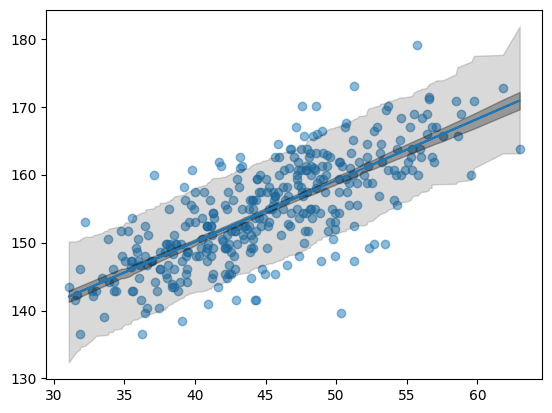

In [131]:
avg_weight = data.weight.mean()

def model(weight, height):
    a = numpyro.sample("a", dist.Normal(138, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (weight - avg_weight))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO(), weight=data.weight.values, height=data.height.values)
svi_result = svi.run(rng_key, 2000)
svi_result.params

samples = guide.sample_posterior(rng_key, svi_result.params, (100,))
mu_hdpi = hpdi(samples["mu"], 0.89, axis=0)
mu_mean = samples["mu"].mean(axis=0)

sims = Predictive(model, samples)(rng_key, data.weight.values, None)
height_hdpi = hpdi(sims["height"], 0.89, axis=0)

plt.scatter(data.weight, data.height, alpha=0.5)
plt.plot(data.weight, mu_mean)

plt.fill_between(sorted(data.weight), sorted(mu_hdpi[0]), sorted(mu_hdpi[1]), alpha=0.3, color="k")
plt.fill_between(sorted(data.weight), sorted(height_hdpi[0]), sorted(height_hdpi[1]), alpha=0.15, color="k")
plt.show()

4H3

In [134]:
data = data_raw.copy()

100%|██████████| 2000/2000 [00:00<00:00, 8284.59it/s, init loss: 37417.7305, avg. loss [1901-2000]: 1727.6921]


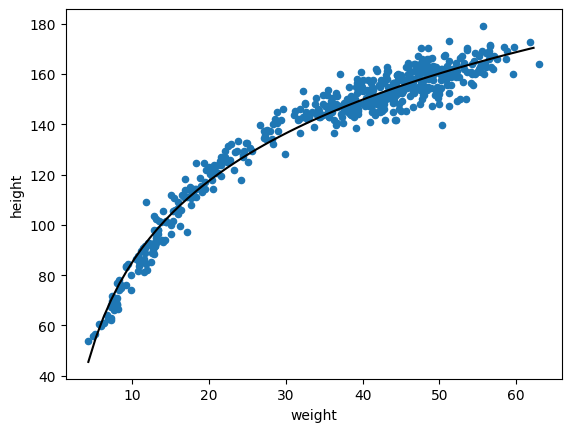

In [135]:
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * jnp.log(weight))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m,
    optim.Adam(0.1),
    Trace_ELBO(),
    weight=data.weight.values,
    height=data.height.values,
)
svi_result = svi.run(rng_key, 2000)
post = m.sample_posterior(rng_key, svi_result.params, (10000,))

weights = jnp.arange(data.weight.min(), data.weight.max(), 1)

sim = Predictive(m.model, post)(rng_key, weights, None)

height_mean = sim["mu"].mean(axis=0)

height_hdpi = hpdi(sim["height"], 0.89, axis=0)

data.plot("weight", "height", kind="scatter")
plt.plot(weights, height_mean, "k")

ad hoc restaurant rating example

In [160]:
# prior ratings
priors = jnp.ones(5)

# collected reviews
reviews_a = jnp.array([0, 0, 0, 0, 10]) + priors
reviews_b = jnp.array([24, 5, 10, 79, 225]) + priors

# sample from posterior
sample_size = 10000
p_a = dist.Dirichlet(reviews_a).sample(rng_key, (sample_size,))
p_b = dist.Dirichlet(reviews_b).sample(rng_key, (sample_size,))

# prior ratings' means based on sampled probs
ratings = jnp.array([1, 2, 3, 4, 5])
post_reviews_mean_a = p_a @ ratings
post_reviews_mean_b = p_b @ ratings

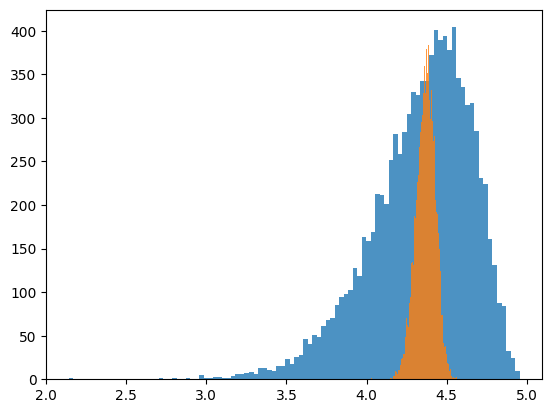

In [161]:
plt.hist(post_reviews_mean_a, bins=100, alpha=0.8)
plt.hist(post_reviews_mean_b, bins=100, alpha=0.8)
plt.show()

0.5202


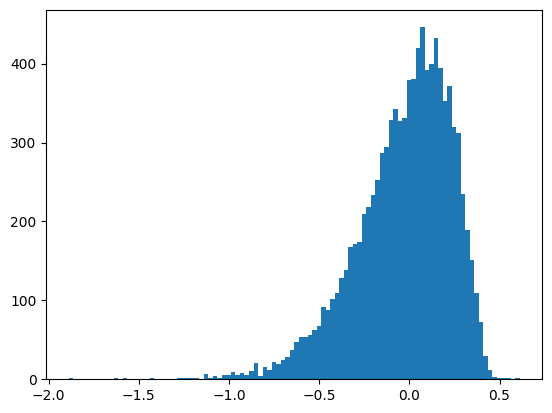

In [141]:
posterior_rating_diff = post_reviews_mean_a-post_reviews_mean_b
p_posterior_better = sum(posterior_rating_diff>0)/len(posterior_rating_diff)
print(p_posterior_better)
plt.hist(posterior_rating_diff, bins=100)
plt.show()